Last modified: 15 June 2020\
Calculate the shifts for multiple shifted images.\

This code is highly based on the code attached to the article "Quantitative analysis of spectroscopic Low Energy Electron Microscopy data: High-dynamic range imaging, drift correction and cluster analysis" by T.A. de Jong et al. See https://github.com/TAdeJong/LEEM-analysis, 2 - Driftcorrection.ipynb. 

In [1]:
import numpy as np
from scipy import ndimage
from skimage import data, io, filters
import matplotlib.pyplot as plt
import dask.array as da

In [2]:
# Import images
d = np.load('drizzle_ims.npy')
np.shape(d)

(100, 200, 200)

In [3]:
data = da.from_array(d,chunks=(1,200,200))
data

,Array,Chunk
Bytes,32.00 MB,320.00 kB
Shape,"(100, 200, 200)","(1, 200, 200)"
Count,101 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [4]:
import numpy as np
import os
import numba
import time
import dask

import dask.array as da
from dask.delayed import delayed
from dask.distributed import Client, LocalCluster
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.optimize import least_squares
import scipy.ndimage as ndi
import scipy.sparse as sp
from scipy.interpolate import interp1d

from skimage import filters

# Most relevant functions can be found in Registration.py
from Registration import *

plt.rcParams["figure.figsize"] = [12., 8.]
SAVEFIG = False

In [5]:
cluster = LocalCluster(n_workers=1, threads_per_worker=4)
client = Client(cluster)
client.upload_file('Registration.py')
client

Client Scheduler: tcp://127.0.0.1:54755 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 8.46 GB


In [6]:
def plot_stack(images, n, grid=False):
    """Plot the n-th image from a stack of n images.
    For interactive use with ipython widgets"""
    im = images[n, :, :].compute()
    plt.figure(figsize=[12,10])
    plt.imshow(im.T, cmap='gray', vmax=np.percentile(im, 99.99))
    if grid:
        plt.grid()
    plt.show()

In [7]:
# A bunch of constants


# Pick the range to apply drift correction
start, stop = 0, -1 #BF 


# A stride larger than 1 takes 1 every stride images of the total dataset. 
# This decreases computation time by a factor of stride**2, but decreases accuracy
stride = 1
# dE is the blocksize used by dask, the number of images computed for at once.
dE = 10

Eslice = slice(start, stop, stride)

# Grab a window of 2*fftsize around the center of the picture
fftsize=64 * 2 // 2
z_factor = 1

sigma = 3 # Sigma of gaussian smoothing

In [8]:
#dataset = xr.open_dataset(os.path.join(folder, name + '_detectorcorrected.nc'), chunks={'time': dE})
original = data
original

,Array,Chunk
Bytes,32.00 MB,320.00 kB
Shape,"(100, 200, 200)","(1, 200, 200)"
Count,101 Tasks,100 Chunks
Type,float64,numpy.ndarray


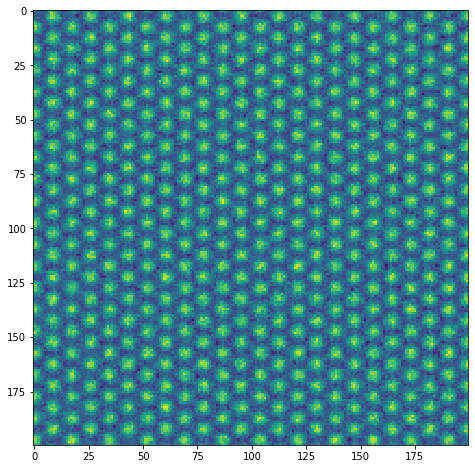

In [9]:
plt.imshow(data[0].compute())

In [10]:
# For interactive use we can view the original data
interactive(lambda n: plot_stack(original, n), 
            n=widgets.IntSlider(original.shape[0]//2, 0, original.shape[0]-1, 1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=50, continuous_update=False, description='n', max=99), Output()), _dom_c…

In [11]:
# Step 1 to 3 of the algorithm as described in section 4 of the paper.
sobel = crop_and_filter(original[Eslice,...].rechunk({0:dE}), sigma=sigma, finalsize=2*fftsize)
sobel = (sobel - sobel.mean(axis=(1,2), keepdims=True)) #.persist()  
sobel

dask.array<sub, shape=(99, 128, 128), dtype=float64, chunksize=(10, 128, 128), chunktype=numpy.ndarray>

In [12]:
# Step 4 of the algorithm as described in paper.
Corr = dask_cross_corr(sobel)
Corr

C:\Users\Arend-Jan\anaconda3\lib\site-packages\dask\array\core.py:3871: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,


dask.array<rechunk-merge, shape=(99, 99, 128, 128), dtype=float64, chunksize=(10, 10, 128, 128), chunktype=numpy.ndarray>

In [13]:
# Plot combination of original images, filtered images, crosscorrelation 
# for illustration purposes
def plot_corr(i,j, save=SAVEFIG):
    #fig = plt.figure(figsize=(8.2, 3.5), constrained_layout=True)
    fig = plt.figure(figsize=(4, 7), constrained_layout=True)
    fig.set_constrained_layout_pads(hspace=0.0, wspace=0.06)
    #gs = mpl.gridspec.GridSpec(2, 3,
    #                   width_ratios=[1, 1, 2.9],
    #                   #height_ratios=[4, 1]
    #                   )
    
    gs = mpl.gridspec.GridSpec(3, 2,
                       height_ratios=[1, 1, 1.8],
                               figure=fig,
                       )
    
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[2, :]) #2grid((2, 4), (0, 2), rowspan=2, colspan=2)
    ax0.imshow(original[i*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T, 
               cmap='gray', interpolation='none')
    ax0.set_title(f'i={i*stride + start}')
    ax1.imshow(sobel[i,...].T, cmap='gray')
    ax2.imshow(original[j*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T,
               cmap='gray', interpolation='none')
    ax2.set_title(f'j={j*stride + start}')
    ax3.imshow(sobel[j,...].T,
               cmap='gray', interpolation='none')
    im = ax4.imshow(Corr[i,j,...].compute().T, extent=[-fftsize, fftsize, -fftsize, fftsize], interpolation='none')
    ax4.axhline(0, color='white', alpha=0.5)
    ax4.axvline(0, color='white', alpha=0.5)
    for ax in [ax2, ax3]:
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelright=True, labelleft=False)
    plt.colorbar(im, ax=ax4)
    if save:
        #Saving Figure for paper.
        plt.savefig('autocorrelation.pdf', dpi=300)
    plt.show()
    return fig


widget = interactive(plot_corr, 
            i=widgets.IntSlider(58-start,0,sobel.shape[0]-1,1, continuous_update=False), 
            j=widgets.IntSlider(100-start,0,sobel.shape[0]-1,1, continuous_update=False),
            save=SAVEFIG
           )
display(widget)

interactive(children=(IntSlider(value=58, continuous_update=False, description='i', max=98), IntSlider(value=9…

In [14]:
# Step 5 of the algorithm
weights, argmax = max_and_argmax(Corr)
weights

dask.array<amax-aggregate, shape=(99, 99), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>

In [15]:
# Do actual computations; get a cup of coffee. If this takes to long, consider increasing stride to reduce the workload, at the cost of accuracy
t = time.monotonic()
W, DX_DY = calculate_halfmatrices(weights, argmax, fftsize=fftsize)
print(time.monotonic()-t)

5.344000000040978


In [16]:
# Step 6 of the algorithm
w_diag = np.atleast_2d(np.diag(W))
W_n = W / np.sqrt(w_diag.T*w_diag)
DX_DY,W,W_n

(array([[[ 0, -1, -1, ...,  6, -1, -1],
         [ 1,  0,  0, ..., -3, -1,  0],
         [ 1,  0,  0, ..., -3,  0,  0],
         ...,
         [-6,  3,  3, ...,  0,  3,  3],
         [ 1,  1,  0, ..., -3,  0,  1],
         [ 1,  0,  0, ..., -3, -1,  0]],
 
        [[ 0,  1,  1, ..., -1,  0,  2],
         [-1,  0,  1, ..., -2, -1,  1],
         [-1, -1,  0, ..., -2, -1,  1],
         ...,
         [ 1,  2,  2, ...,  0,  1,  3],
         [ 0,  1,  1, ..., -1,  0,  2],
         [-2, -1, -1, ..., -3, -2,  0]]], dtype=int64),
 array([[86397.41947045, 69296.80522463, 69169.07234869, ...,
         69770.93737714, 70918.07651707, 66859.47098328],
        [69296.80522463, 87404.57237957, 68076.90545322, ...,
         64038.41967894, 69413.9050661 , 67734.93249292],
        [69169.07234869, 68076.90545322, 86466.24403941, ...,
         66860.21637274, 63207.27373257, 69508.69374343],
        ...,
        [69770.93737714, 64038.41967894, 66860.21637274, ...,
         84207.95985582, 63423.4638021

In [17]:
# Plot W, DX and DY to pick a value for W_{min} (Step 7 of algorithm)
def plot_masking(min_normed_weight, save=SAVEFIG):
    extent = [start, stop, stop, start]
    fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
    im = {}
    im[0] = axs[0].imshow(DX_DY[0], cmap='seismic', extent=extent, interpolation='none')
    im[1] = axs[1].imshow(DX_DY[1], cmap='seismic', extent=extent, interpolation='none')
    im[2] = axs[2].imshow(W_n - np.diag(np.diag(W_n)), cmap='inferno', 
                          extent=extent, clim=(0.0, None), interpolation='none')
    axs[0].set_ylabel('$j$')
    fig.colorbar(im[0], ax=axs[:2], shrink=0.82, fraction=0.1)
    axs[0].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    axs[1].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    CF = axs[2].contourf(W_n, [0, min_normed_weight], 
                         colors='white', alpha=0.2, 
                         extent=extent, origin='upper')
    cbar = fig.colorbar(im[2], ax=axs[2], shrink=0.82, fraction=0.1)
    cbar.ax.fill_between([0,1], 0, min_normed_weight, color='white', alpha=0.2)
    for i in range(3):            
        axs[i].set_xlabel('$i$')
        axs[i].tick_params(labelbottom=False, labelleft=False)  
    axs[0].set_title('$DX_{ij}$')
    axs[1].set_title('$DY_{ij}$')
    axs[2].set_title('$W_{ij}$')
    if save:
        plt.savefig('shiftsandweights.pdf', dpi=300)
    plt.show()
    return min_normed_weight


widget = interactive(plot_masking, 
                     min_normed_weight=widgets.FloatSlider(value=0.15, min=0., max=1, 
                                                      step=0.01, continuous_update=False),
                     save=SAVEFIG
               )
display(widget)

interactive(children=(FloatSlider(value=0.15, continuous_update=False, description='min_normed_weight', max=1.…

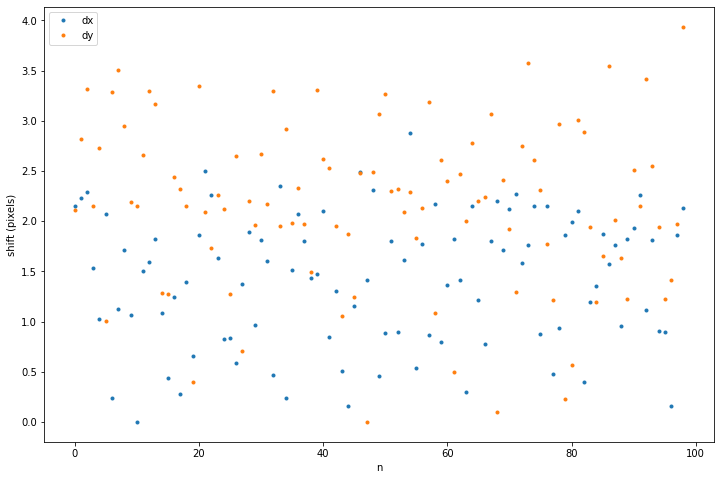

In [18]:
# Part two of step 7 of the algorithm
min_norm = widget.result
nr = np.arange(W.shape[0])*stride + start
coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(min_norm, W, DX_DY, nr)

#Step 8 of the algorithm: reduce the shift matrix to two vectors of absolute shifts
dx, dy = calc_shift_vectors(DX, DY, weightmatrix)
plt.plot(coords, dx, '.', label='dx')
plt.plot(coords, dy, '.', label='dy')
plt.xlabel('n')
plt.ylabel('shift (pixels)')
plt.legend()

In [19]:
# Interpolate the shifts for all values not in coords
shifts = np.stack(interp_shifts(coords, [dx, dy], n=original.shape[0]), axis=1)
neededMargins = np.ceil(shifts.max(axis=0)).astype(int)
shifts = da.from_array(shifts, chunks=(dE,-1))
shifts

dask.array<array, shape=(100, 2), dtype=float64, chunksize=(10, 2), chunktype=numpy.ndarray>

In [21]:
#Save shifts
shifts = shifts.compute()
np.save('calculated_shifts.npy', shifts)